<a href="https://colab.research.google.com/github/suleymansennn/Scoutium_Talenter_Hunting/blob/main/Scoutium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Makine Öğrenmesi ile Yetenek Avcılığı Sınıflandırma
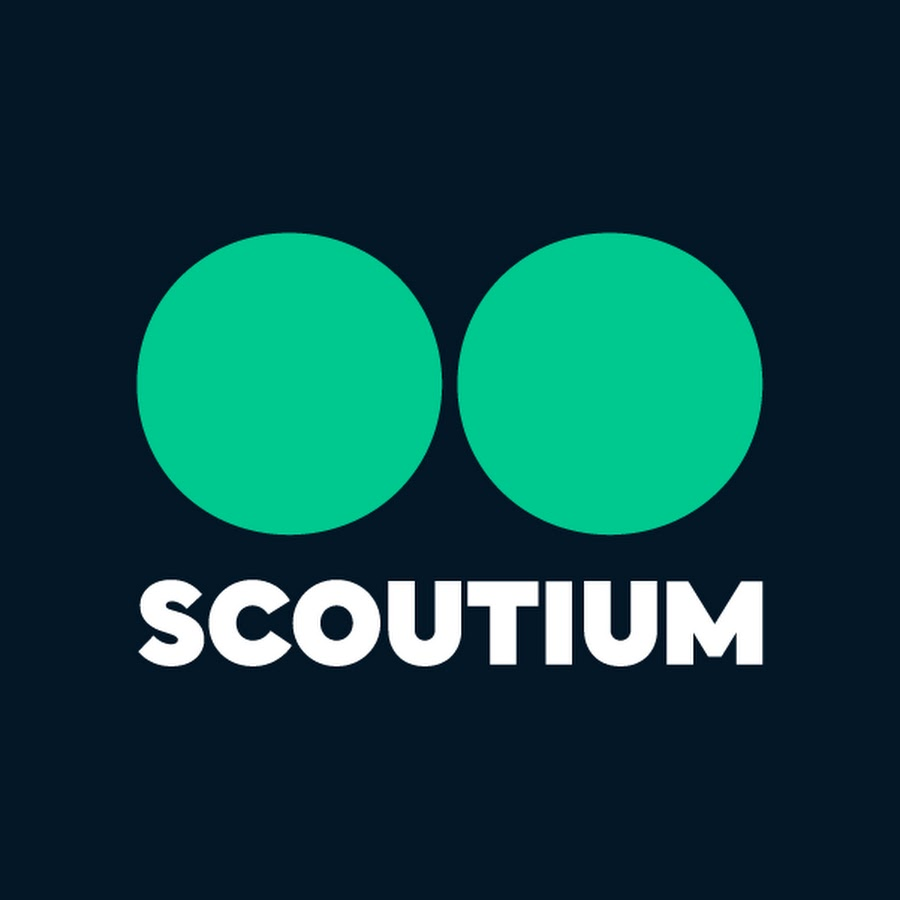

# İş Problemi

- Scout'lar tarafından izlenen futbolcuların özelliklerine verilen puanlara göre, oyuncuların hangi sınıf oyuncu olduğunu tahminleme

# Veri Seti Hikayesi 
- Veri seti Scoutium'dan maçlarda gözlemlenen futbolcuların özelliklerine göre scoutların değerlendirdikleri futbolcuların, maç içerisinde puanlanan özellikleri ve puanlarını içeren bilgilerden oluşmaktadır.
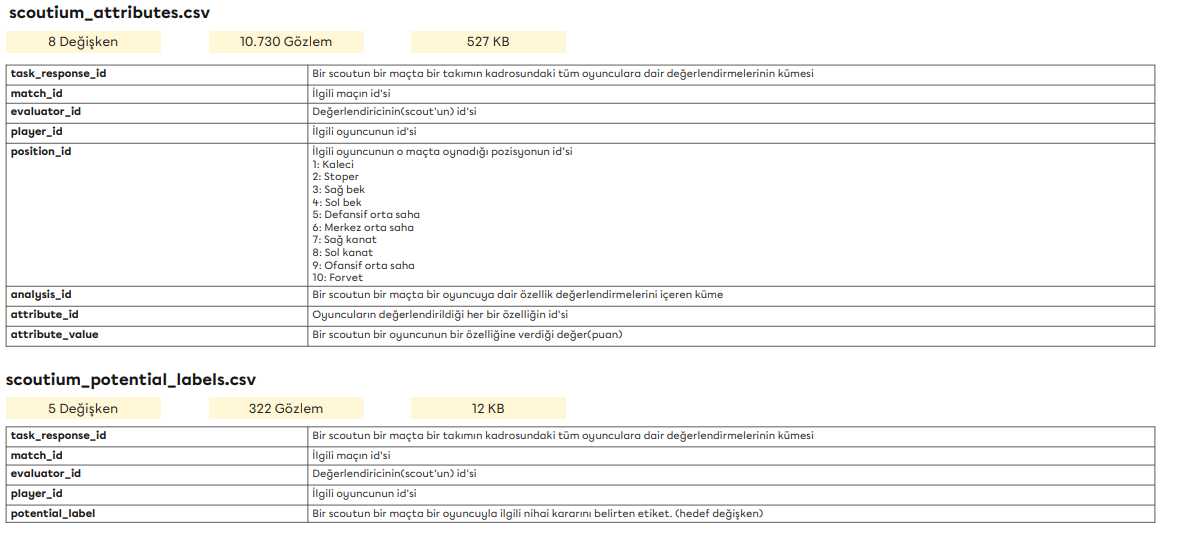

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc, rcParams

import itertools
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix


metric_colors = ['#393E46', '#4649FF', '#54B435']
cat_feat_colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]

pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
att = pd.read_csv("/content/scoutium_attributes.csv", sep=";")
labels = pd.read_csv("/content/scoutium_potential_labels.csv", sep=";")

att.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [ ]:
labels.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [ ]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=False)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df).sort_values(by="Ratio", ascending=False)
    return missing_df

def check_df(dataframe, head=5, tail=5):
    print("*" * 70)
    print(" Shape ".center(70, "*"))
    print("*" * 70)
    print(dataframe.shape)

    print("*" * 70)
    print(" Types ".center(70, "*"))
    print("*" * 70)
    print(dataframe.dtypes)

    print("*" * 70)
    print(" Head ".center(70, "*"))
    print("*" * 70)
    print(dataframe.head(head))

    print("*" * 70)
    print(" Tail ".center(70, "*"))
    print("*" * 70)
    print(dataframe.tail(tail))

    print("*" * 70)
    print(" NA ".center(70, "*"))
    print("*" * 70)
    print(missing_values_analysis(dataframe))

    print("*" * 70)
    print(" Quantiles ".center(70, "*"))
    print("*" * 70)
    print(dataframe.describe([.01, .05, .1, .5, .9, .95, .99]).T)

    print("*" * 70)
    print(" Duplicate Rows ".center(70, "*"))
    print("*" * 70)
    print(dataframe.duplicated().sum())

    print("*" * 70)
    print(" Uniques ".center(70, "*"))
    print("*" * 70)
    print(dataframe.nunique())


check_df(att)

**********************************************************************
******************************* Shape ********************************
**********************************************************************
(10730, 8)
**********************************************************************
******************************* Types ********************************
**********************************************************************
task_response_id      int64
match_id              int64
evaluator_id          int64
player_id             int64
position_id           int64
analysis_id           int64
attribute_id          int64
attribute_value     float64
dtype: object
**********************************************************************
******************************** Head ********************************
**********************************************************************
   task_response_id  match_id  evaluator_id  player_id  position_id  analysis_id  attribute_id  attribute_value


In [ ]:
check_df(labels)

**********************************************************************
******************************* Shape ********************************
**********************************************************************
(322, 5)
**********************************************************************
******************************* Types ********************************
**********************************************************************
task_response_id     int64
match_id             int64
evaluator_id         int64
player_id            int64
potential_label     object
dtype: object
**********************************************************************
******************************** Head ********************************
**********************************************************************
   task_response_id  match_id  evaluator_id  player_id potential_label
0              4915     62935        177676    1361061         average
1              4915     62935        177676    1361626     hi

In [ ]:
df = pd.merge(att, labels, how="right", on=["task_response_id", "match_id", "evaluator_id", "player_id"])
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [ ]:
missing_values_analysis(df)

,Total Missing Values,Ratio
attribute_id,,


In [ ]:
df.groupby("evaluator_id").agg({"attribute_value": ["mean", "median", "count"]})

attribute_value             
                        mean median count
evaluator_id                             
130478             34.909774   34.0   399
132337             64.794486   67.0   798
135624             43.649123   45.0   399
141254             42.738523   45.0   501
151191             68.909288   67.0  3693
160289             61.962740   67.0   832
173255             50.515068   56.0   365
177676             50.750645   56.0  1163
186987             29.569863   34.0   365
256441             42.576524   45.0  2215

In [ ]:
df = pd.pivot_table(data=df, index=["player_id", "position_id", "potential_label"], columns="attribute_id",
                    values="attribute_value").reset_index()

check_df(df)

**********************************************************************
******************************* Shape ********************************
**********************************************************************
(301, 42)
**********************************************************************
******************************* Types ********************************
**********************************************************************
attribute_id
player_id            int64
position_id          int64
potential_label     object
4322               float64
4323               float64
4324               float64
4325               float64
4326               float64
4327               float64
4328               float64
4329               float64
4330               float64
4332               float64
4333               float64
4335               float64
4336               float64
4337               float64
4338               float64
4339               float64
4340               float64
4341       

In [ ]:
df.columns = df.columns.astype(str)
df.loc[df["4409"].notnull()]

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4336,4337,4338,4339,4340,4341,4342,4343,4344,4345,4346,4347,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4409,4423,4426
7,1356422,1,average,67.000000,67.000000,56.0,56.000000,67.000000,67.000000,78.000000,78.000000,56.0,67.0,NaN,NaN,78.0,56.000000,78.000000,NaN,NaN,NaN,56.000000,NaN,NaN,NaN,45.000000,78.0,NaN,NaN,78.000000,NaN,67.000000,67.000000,78.000000,67.000000,NaN,78.0,NaN,NaN,67.0,56.000000,56.0
8,1358072,1,average,56.000000,56.000000,45.0,45.000000,45.000000,45.000000,45.000000,45.000000,34.0,45.0,NaN,NaN,45.0,45.000000,34.000000,NaN,NaN,NaN,34.000000,NaN,NaN,NaN,45.000000,56.0,NaN,NaN,45.000000,NaN,45.000000,45.000000,45.000000,45.000000,NaN,45.0,NaN,NaN,45.0,23.000000,34.0
9,1358124,1,average,45.000000,45.000000,34.0,45.000000,45.000000,56.000000,56.000000,45.000000,45.0,45.0,NaN,NaN,34.0,34.000000,45.000000,NaN,NaN,NaN,45.000000,NaN,NaN,NaN,34.000000,34.0,NaN,NaN,45.000000,NaN,45.000000,34.000000,34.000000,34.000000,NaN,45.0,NaN,NaN,56.0,34.000000,45.0
10,1358179,1,average,56.000000,67.000000,45.0,45.000000,34.000000,56.000000,67.000000,45.000000,45.0,56.0,NaN,NaN,67.0,45.000000,45.000000,NaN,NaN,NaN,45.000000,NaN,NaN,NaN,34.000000,78.0,NaN,NaN,56.000000,NaN,45.000000,67.000000,23.000000,45.000000,NaN,34.0,NaN,NaN,56.0,45.000000,45.0
21,1359409,1,average,78.000000,78.000000,67.0,67.000000,67.000000,67.000000,67.000000,78.000000,67.0,67.0,NaN,NaN,67.0,67.000000,67.000000,NaN,NaN,NaN,67.000000,NaN,NaN,NaN,67.000000,67.0,NaN,NaN,67.000000,NaN,67.000000,67.000000,78.000000,67.000000,NaN,67.0,NaN,NaN,78.0,67.000000,78.0
54,1366311,1,average,67.000000,67.000000,67.0,67.000000,67.000000,67.000000,67.000000,67.000000,67.0,67.0,NaN,NaN,67.0,56.000000,67.000000,NaN,NaN,NaN,67.000000,NaN,NaN,NaN,67.000000,67.0,NaN,NaN,67.000000,NaN,67.000000,67.000000,67.000000,67.000000,NaN,67.0,NaN,NaN,67.0,56.000000,78.0
55,1366350,1,average,67.000000,67.000000,67.0,67.000000,67.000000,67.000000,67.000000,78.000000,67.0,67.0,NaN,NaN,67.0,67.000000,67.000000,NaN,NaN,NaN,67.000000,NaN,NaN,NaN,67.000000,67.0,NaN,NaN,67.000000,NaN,67.000000,67.000000,78.000000,67.000000,NaN,67.0,NaN,NaN,67.0,67.000000,78.0
69,1367745,1,average,67.000000,78.000000,67.0,67.000000,67.000000,67.000000,67.000000,78.000000,67.0,67.0,NaN,NaN,67.0,67.000000,67.000000,NaN,NaN,NaN,67.000000,NaN,NaN,NaN,67.000000,67.0,NaN,NaN,67.000000,NaN,67.000000,67.000000,78.000000,67.000000,NaN,67.0,NaN,NaN,78.0,56.000000,78.0
82,1369060,1,average,52.333333,48.666667,45.0,52.333333,48.666667,52.333333,52.333333,48.666667,45.0,56.0,NaN,NaN,45.0,52.333333,52.333333,NaN,NaN,NaN,48.666667,NaN,NaN,NaN,52.333333,56.0,NaN,NaN,48.666667,NaN,52.333333,52.333333,48.666667,48.666667,NaN,45.0,NaN,NaN,45.0,37.666667,45.0
83,1369061,1,highlighted,67.000000,67.000000,56.0,56.000000,67.000000,67.000000,78.000000,67.000000,67.0,67.0,NaN,NaN,78.0,67.000000,67.000000,NaN,NaN,NaN,56.000000,NaN,NaN,NaN,56.000000,78.0,NaN,NaN,56.000000,NaN,56.000000,67.000000,56.000000,56.000000,NaN,78.0,NaN,NaN,56.0,56.000000,67.0


In [ ]:
df.drop(df.loc[df["position_id"] == 1].index.tolist(), axis=0, inplace=True)
df.drop(["4409", "4346", "4337", "4336", "4347"], axis=1, inplace=True)
missing_values_analysis(df)

,Total Missing Values,Ratio
attribute_id,,


####################################################################################################
average          215
highlighted       56
below_average      4
Name: potential_label, dtype: int64


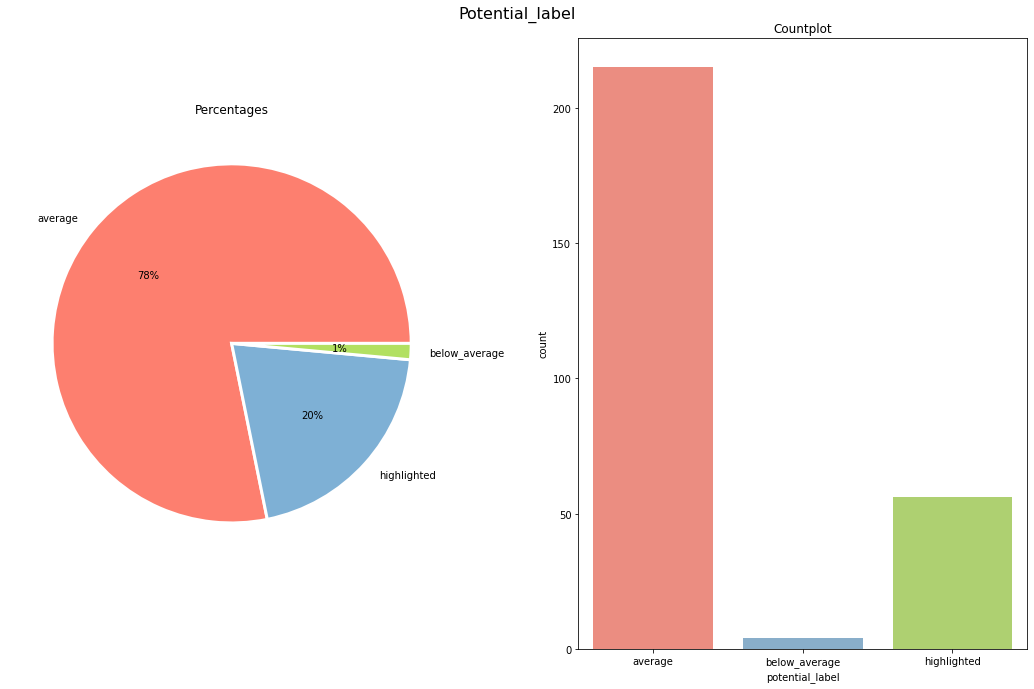

In [ ]:
def cat_plots(dataframe, cat_col):
    print("".center(100, "#"))
    print(dataframe[cat_col].value_counts())

    plt.figure(figsize=(15, 10))
    plt.suptitle(cat_col.capitalize(), size=16)
    plt.subplot(1, 2, 1)
    plt.title("Percentages")
    plt.pie(dataframe[cat_col].value_counts().values.tolist(),
            labels=dataframe[cat_col].value_counts().keys().tolist(),
            labeldistance=1.1,
            wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
            colors=cat_feat_colors,
            autopct='%1.0f%%')

    plt.subplot(1, 2, 2)
    plt.title("Countplot")
    sns.countplot(data=dataframe, x=cat_col, palette=cat_feat_colors)
    plt.tight_layout(pad=3)
    plt.show(block=True)

cat_plots(df, "potential_label")

In [ ]:
df.drop(df.loc[df["potential_label"] == "below_average"].index.tolist(), axis=0, inplace=True)

In [ ]:
average_player = df.loc[df["potential_label"] == "average"].sample(1)
highlighted_player = df.loc[df["potential_label"] == "highlighted"].sample(1)
highlighted_player

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
37,1361626,10,highlighted,56.0,67.0,78.0,78.0,56.0,56.0,78.0,67.0,78.0,67.0,67.0,67.0,67.0,56.0,56.0,67.0,67.0,67.0,100.0,78.0,56.0,56.0,78.0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,78.0,56.0,78.0,67.0


In [ ]:
num_cols = df.columns[3:]
num_cols

Index(['4322', '4323', '4324', '4325', '4326', '4327', '4328', '4329', '4330',
       '4332', '4333', '4335', '4338', '4339', '4340', '4341', '4342', '4343',
       '4344', '4345', '4348', '4349', '4350', '4351', '4352', '4353', '4354',
       '4355', '4356', '4357', '4407', '4408', '4423', '4426'],
      dtype='object', name='attribute_id')

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=highlighted_player[num_cols].to_numpy()[0],
      theta=num_cols.tolist(),
      fill='toself',
      name='Highlighted Player'
))
fig.add_trace(go.Scatterpolar(
      r=average_player[num_cols].to_numpy()[0],
      theta=num_cols.tolist(),
      fill='toself',
      name='Average Player'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  showlegend=True
)

fig.show()

# Model

In [ ]:
df["potential_label"] = np.where(df["potential_label"] == "average", 0, 1)

In [ ]:
X = df.drop(["player_id",	"position_id",	"potential_label"], axis=1)
y = df["potential_label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=42)
y_train.value_counts()

0    171
1     45
Name: potential_label, dtype: int64

In [ ]:
y_test.value_counts()

0    44
1    11
Name: potential_label, dtype: int64

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.rcParams.update({'font.size': 19})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontdict={'size':'16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=12,color="blue")
    plt.yticks(tick_marks, classes,fontsize=12,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'16'})
    plt.xlabel('Predicted label',fontdict={'size':'16'})
    plt.tight_layout()
    plt.show(block=True)

     Scores   Metrics
0  0.800000  Accuracy
1  0.799587   ROC-AUC
2  0.560000  F1-Score


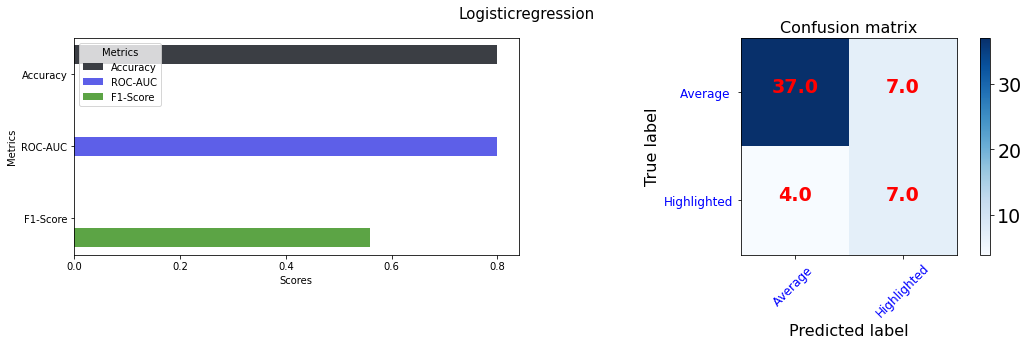

     Scores   Metrics
0  0.872727  Accuracy
1  0.847107   ROC-AUC
2  0.533333  F1-Score


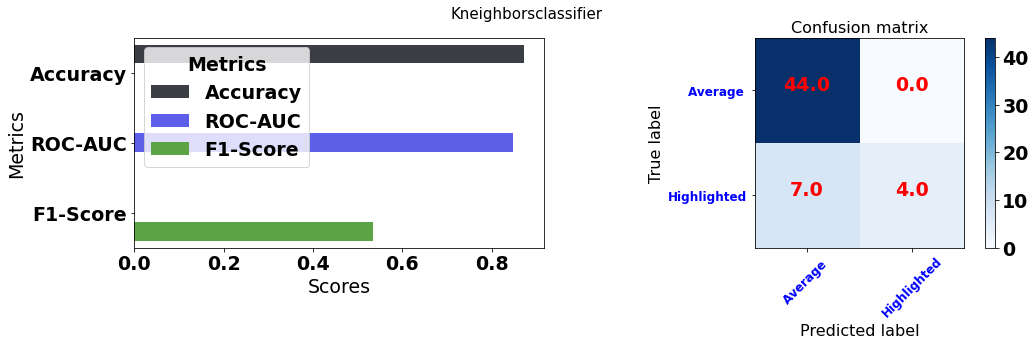

     Scores   Metrics
0  0.945455  Accuracy
1  0.935950   ROC-AUC
2  0.842105  F1-Score


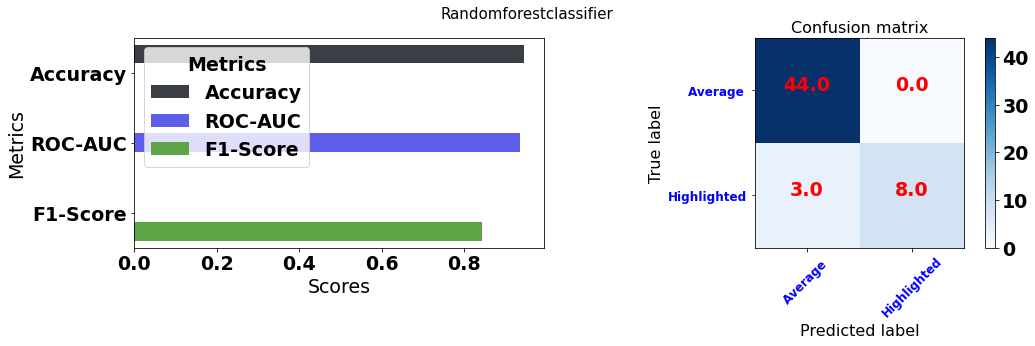

     Scores   Metrics
0  0.890909  Accuracy
1  0.882231   ROC-AUC
2  0.727273  F1-Score


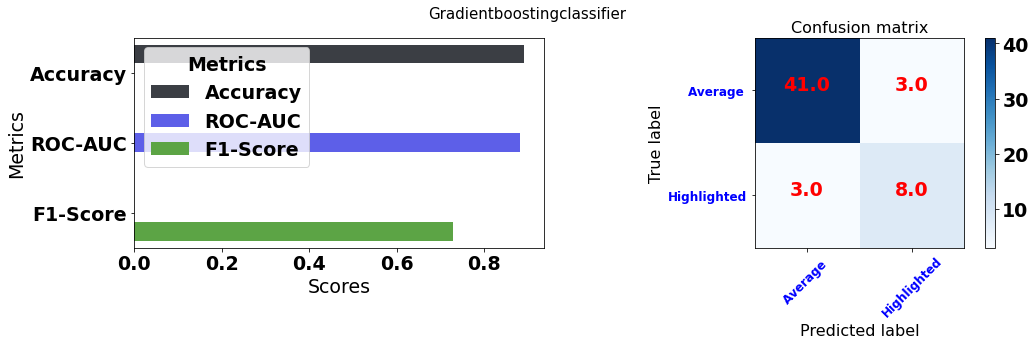

     Scores   Metrics
0  0.872727  Accuracy
1  0.882231   ROC-AUC
2  0.695652  F1-Score


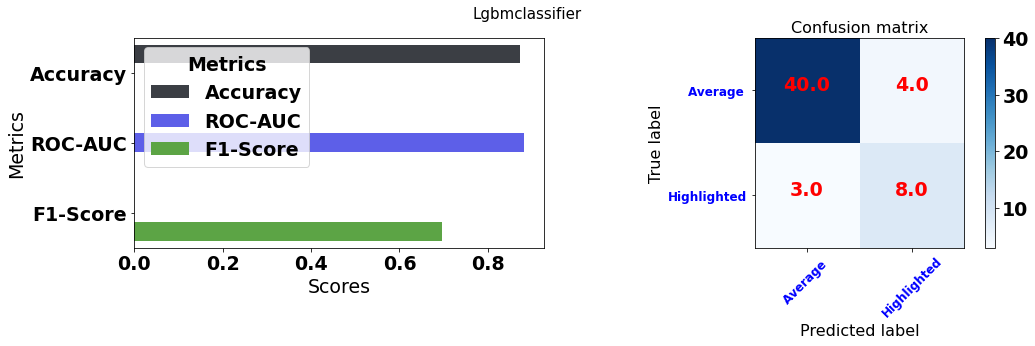

     Scores   Metrics
0  0.927273  Accuracy
1  0.890496   ROC-AUC
2  0.818182  F1-Score


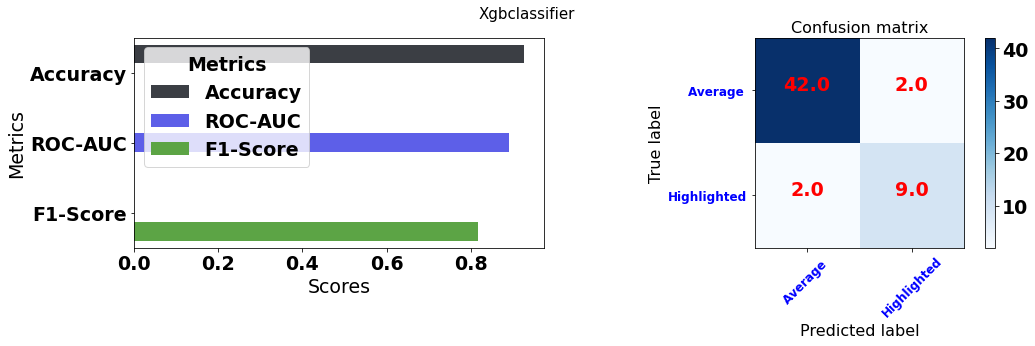

     Scores   Metrics
0  0.818182  Accuracy
1  0.784091   ROC-AUC
2  0.615385  F1-Score


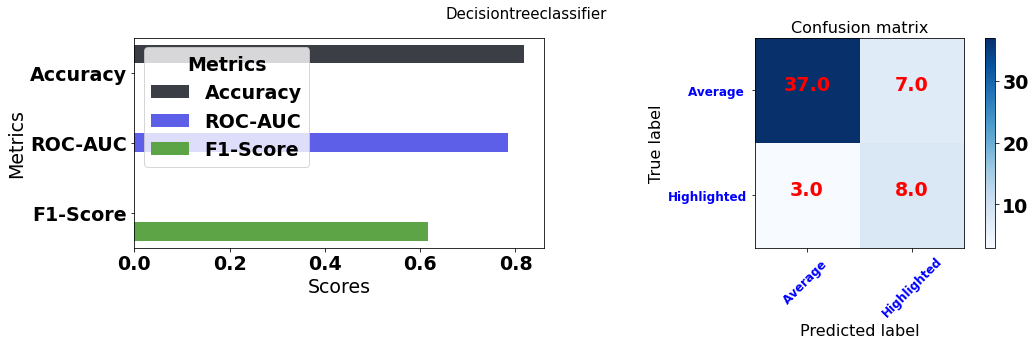

     Scores   Metrics
0  0.927273  Accuracy
1  0.948347   ROC-AUC
2  0.818182  F1-Score


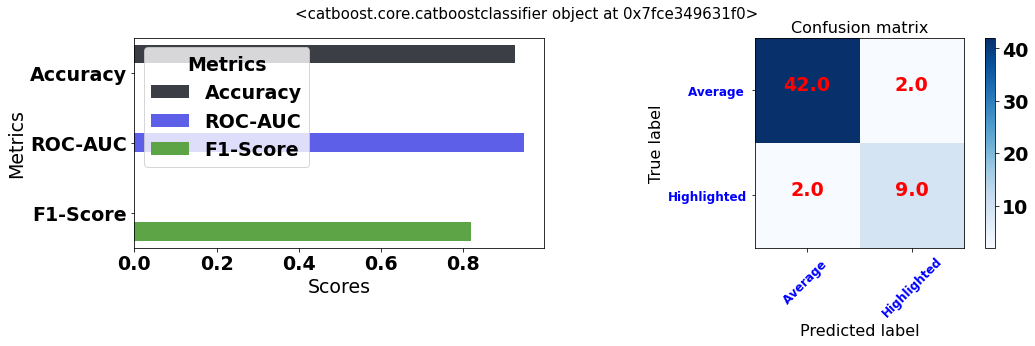

In [ ]:
def base_models(model):
    
    y_pred = model.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    f1 = f1_score(y_test, y_pred)
    mt_dataframe = pd.DataFrame({'Scores': [accuracy, roc_auc, f1],
                                 'Metrics': ['Accuracy',
                                             'ROC-AUC',
                                             'F1-Score']})
    print(mt_dataframe)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.suptitle(str(model).split("(")[0].capitalize(), size=15)
    sns.barplot(data=mt_dataframe, x="Scores", y="Metrics", hue="Metrics", palette=metric_colors)
    plt.legend(loc='upper left', title='Metrics')
    
    plt.subplot(1, 2, 2)
    
    plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=["Average ", "Highlighted"],
                          title='Confusion matrix')

ml_models = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    LGBMClassifier(random_state=42),
    XGBClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    CatBoostClassifier(verbose=False)
]

for model in ml_models:
    base_models(model)

In [ ]:
xgboost_model = XGBClassifier()

In [ ]:
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print(cv_results['test_accuracy'].mean())

print(cv_results['test_f1'].mean())

print(cv_results['test_roc_auc'].mean())

0.8746127946127945
0.6477752639517346
0.8675475687103594


In [ ]:
xgboost_params = {"learning_rate": [0.1, 0.01, 0.5],
                  "max_depth": [2, 3, 5, 8, 10],
                  "n_estimators": [100, 200, 500, 1000],
                  "colsample_bytree": [0.5, 0.7, 1]}
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, verbose=True, n_jobs=-1).fit(X, y)
xgboost_best_grid.best_params_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100}

In [ ]:
best_params = {'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100}

In [ ]:
xgboost_final = xgboost_model.set_params(**best_params, random_state=17).fit(X, y)

cv_results = cross_validate(xgboost_final, X, y,
                            cv=5, scoring=["accuracy", "f1", "roc_auc"])

print(cv_results["test_accuracy"].mean())
print(cv_results["test_f1"].mean())
print(cv_results["test_roc_auc"].mean())

0.8819528619528618
0.6654349376114082
0.8778012684989429


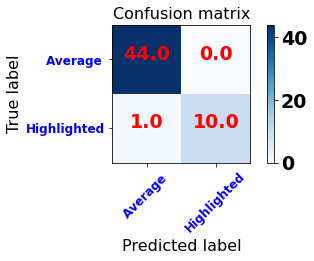

In [ ]:
y_pred = xgboost_final.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=["Average ", "Highlighted"],
                          title='Confusion matrix')

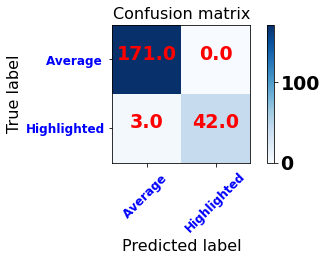

In [ ]:
y_pred = xgboost_final.predict(X_train)
plot_confusion_matrix(confusion_matrix(y_train, y_pred=y_pred), classes=["Average ", "Highlighted"],
                          title='Confusion matrix')